In [1]:
import numpy as np
import torch
import pyepo

# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.1424
0 -> 10 -> 15 -> 8 -> 5 -> 3 -> 17 -> 1 -> 6 -> 13 -> 19 -> 11 -> 18 -> 7 -> 2 -> 14 -> 12 -> 4 -> 9 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.83it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 136.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.91it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.54it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper
from clipgrad import clipGrad

def pipeline(reg, forward_func, loss_func, lr, num_epochs, 
             log_step, loader_train, loader_val, loader_test, grad_clip=False, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
    # restore best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 10 Samples

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=10)

(CVXPY) Dec 04 02:19:47 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 1


In [14]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 216.6579%, Val Regret: 224.0108%


Epoch    0, Loss:  -0.9999:   5%|██▊                                                    | 1/20 [00:19<03:18, 10.44s/it]

Epoch   1, Train Regret:  76.4595%, Val Regret:  73.3728%


Epoch    1, Loss:  -0.9999:  10%|█████▌                                                 | 2/20 [00:30<03:10, 10.57s/it]

Epoch   2, Train Regret:  13.9969%, Val Regret:  15.1311%


Epoch    2, Loss:  -0.9999:  15%|████████▎                                              | 3/20 [00:41<03:00, 10.64s/it]

Epoch   3, Train Regret:  13.7603%, Val Regret:  13.5855%


Epoch    3, Loss:  -0.9999:  20%|███████████                                            | 4/20 [00:52<02:52, 10.79s/it]

Epoch   4, Train Regret:  13.5081%, Val Regret:  13.5011%


Epoch    4, Loss:  -0.9999:  25%|█████████████▊                                         | 5/20 [01:03<02:43, 10.89s/it]

Epoch   5, Train Regret:  13.5822%, Val Regret:  14.4867%


Epoch    5, Loss:  -0.9999:  30%|████████████████▌                                      | 6/20 [01:15<02:33, 10.94s/it]

Epoch   6, Train Regret:  13.2472%, Val Regret:  13.6480%


Epoch    6, Loss:  -0.9999:  35%|███████████████████▎                                   | 7/20 [01:27<02:42, 12.49s/it]


Epoch   7, Train Regret:  13.6995%, Val Regret:  14.3155%

Early Stop!

Evaluation:
Test Regret: 13.9713%
Training Elapsed Time: 1.88 Sec


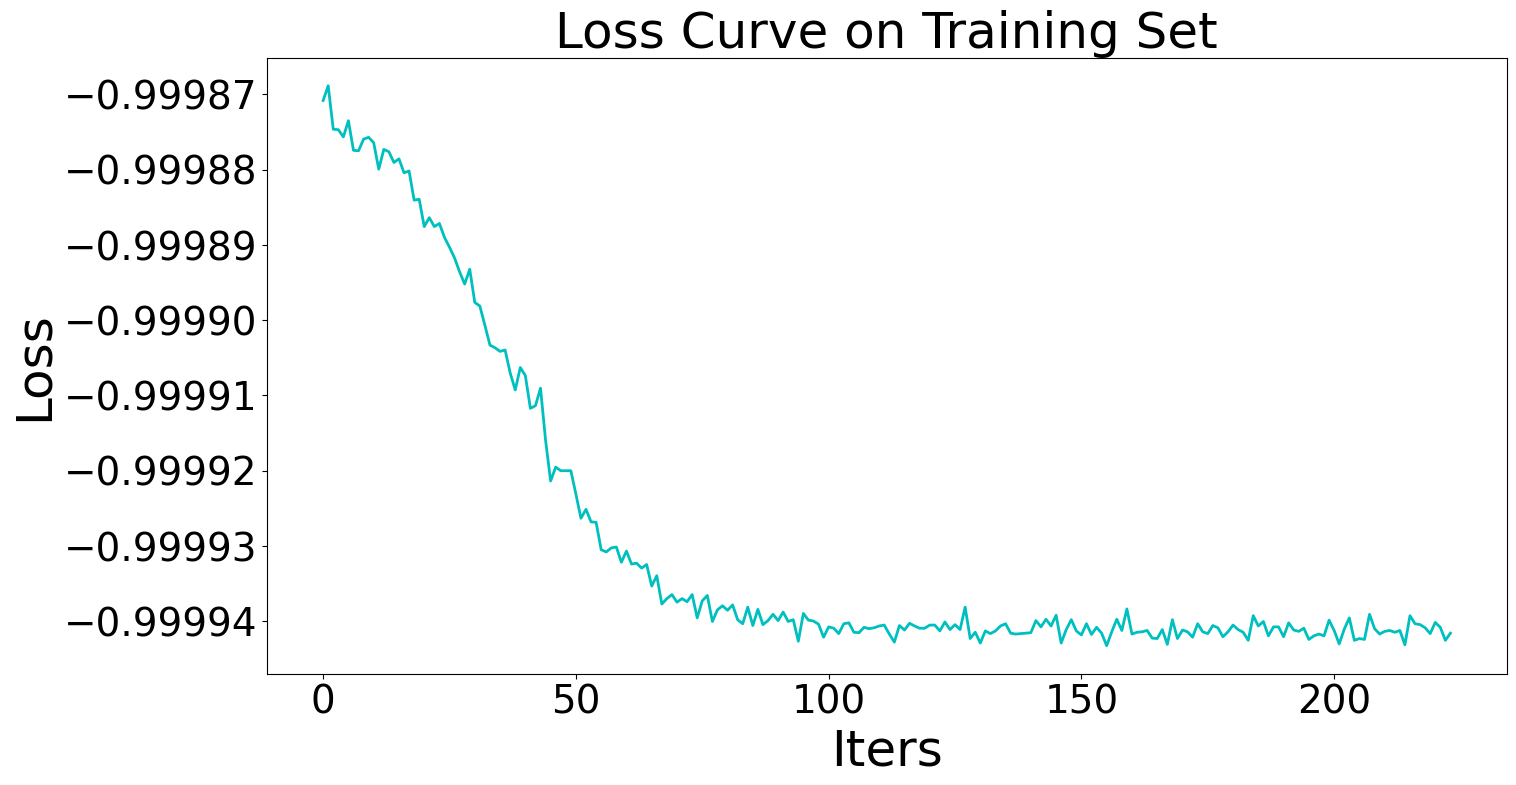

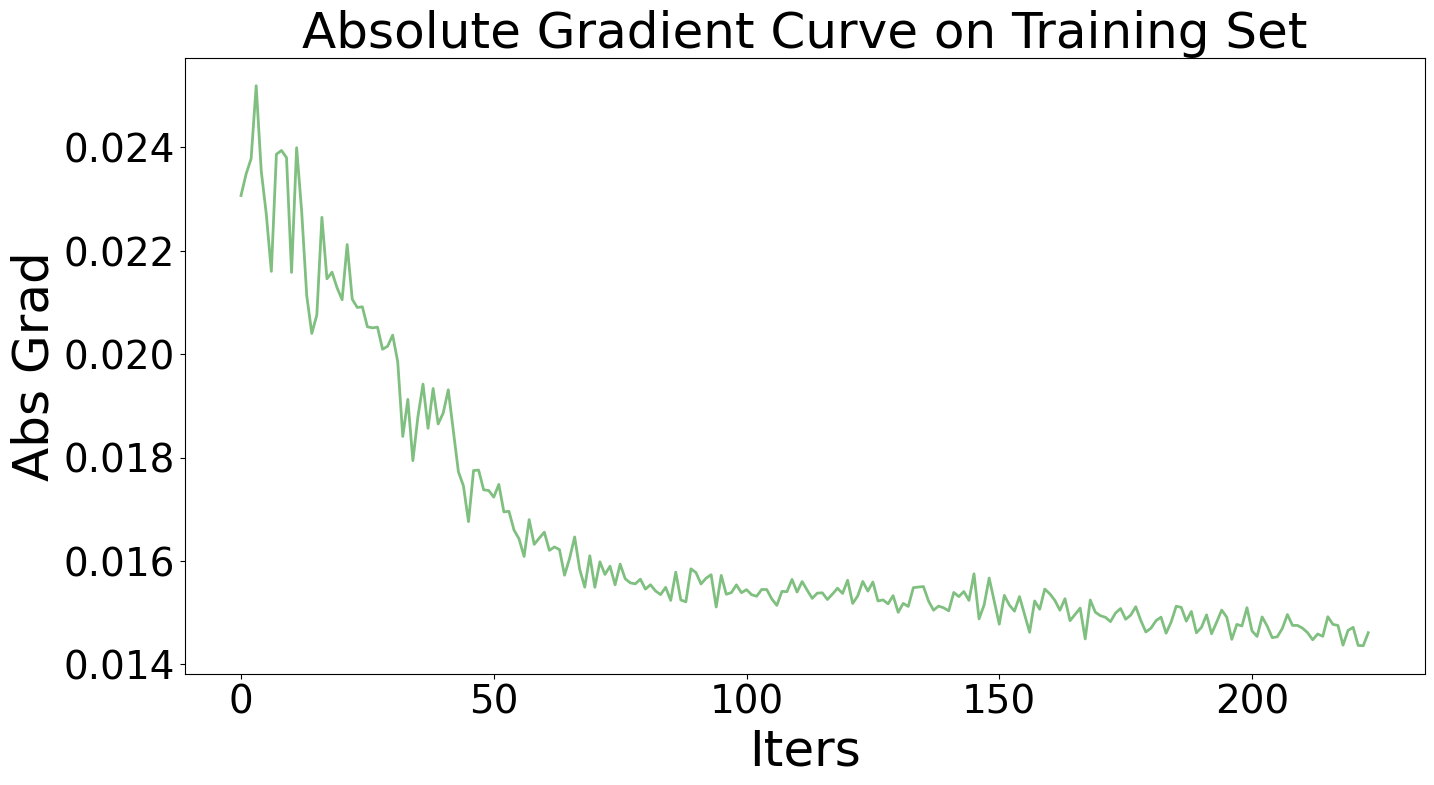

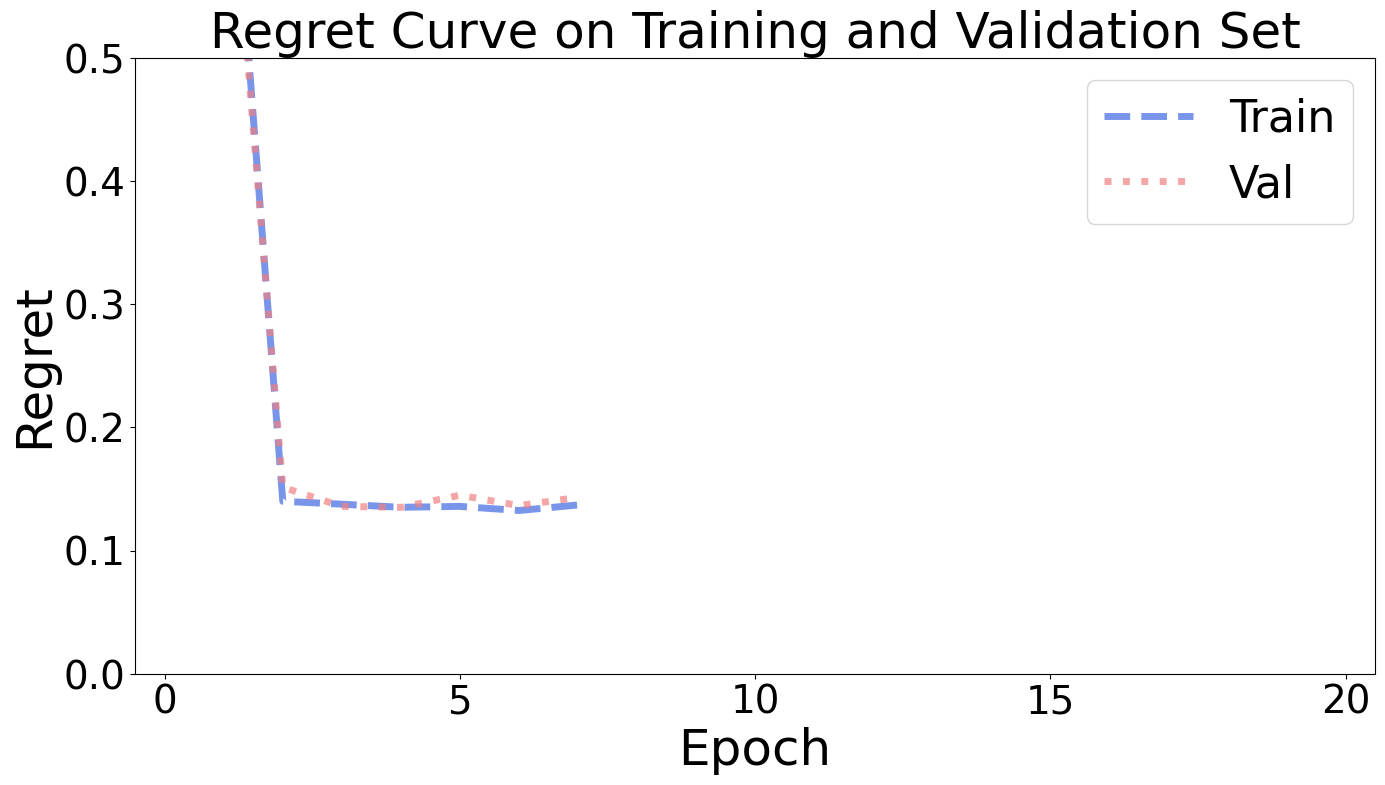

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### 100 Samples 

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

Num of cores: 1


In [18]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:11<?, ?it/s]

Epoch   0, Train Regret: 189.7820%, Val Regret: 198.5544%


Epoch    0, Loss:  -0.9999:   5%|██▊                                                    | 1/20 [00:23<04:08, 13.06s/it]

Epoch   1, Train Regret:  55.6915%, Val Regret:  58.6965%


Epoch    1, Loss:  -0.9999:  10%|█████▌                                                 | 2/20 [00:34<03:42, 12.37s/it]

Epoch   2, Train Regret:  13.6104%, Val Regret:  13.9949%


Epoch    2, Loss:  -0.9999:  15%|████████▎                                              | 3/20 [00:46<03:24, 12.03s/it]

Epoch   3, Train Regret:  13.5121%, Val Regret:  13.5534%


Epoch    3, Loss:  -0.9999:  20%|███████████                                            | 4/20 [00:57<03:08, 11.79s/it]

Epoch   4, Train Regret:  13.4537%, Val Regret:  12.6589%


Epoch    4, Loss:  -0.9999:  25%|█████████████▊                                         | 5/20 [01:09<02:54, 11.63s/it]

Epoch   5, Train Regret:  13.5046%, Val Regret:  13.6218%


Epoch    5, Loss:  -0.9999:  30%|████████████████▌                                      | 6/20 [01:21<02:44, 11.72s/it]

Epoch   6, Train Regret:  13.0956%, Val Regret:  13.6877%


Epoch    6, Loss:  -0.9999:  35%|███████████████████▎                                   | 7/20 [01:35<02:56, 13.61s/it]


Epoch   7, Train Regret:  13.3603%, Val Regret:  12.9550%

Early Stop!

Evaluation:
Test Regret: 13.9518%
Training Elapsed Time: 5.67 Sec


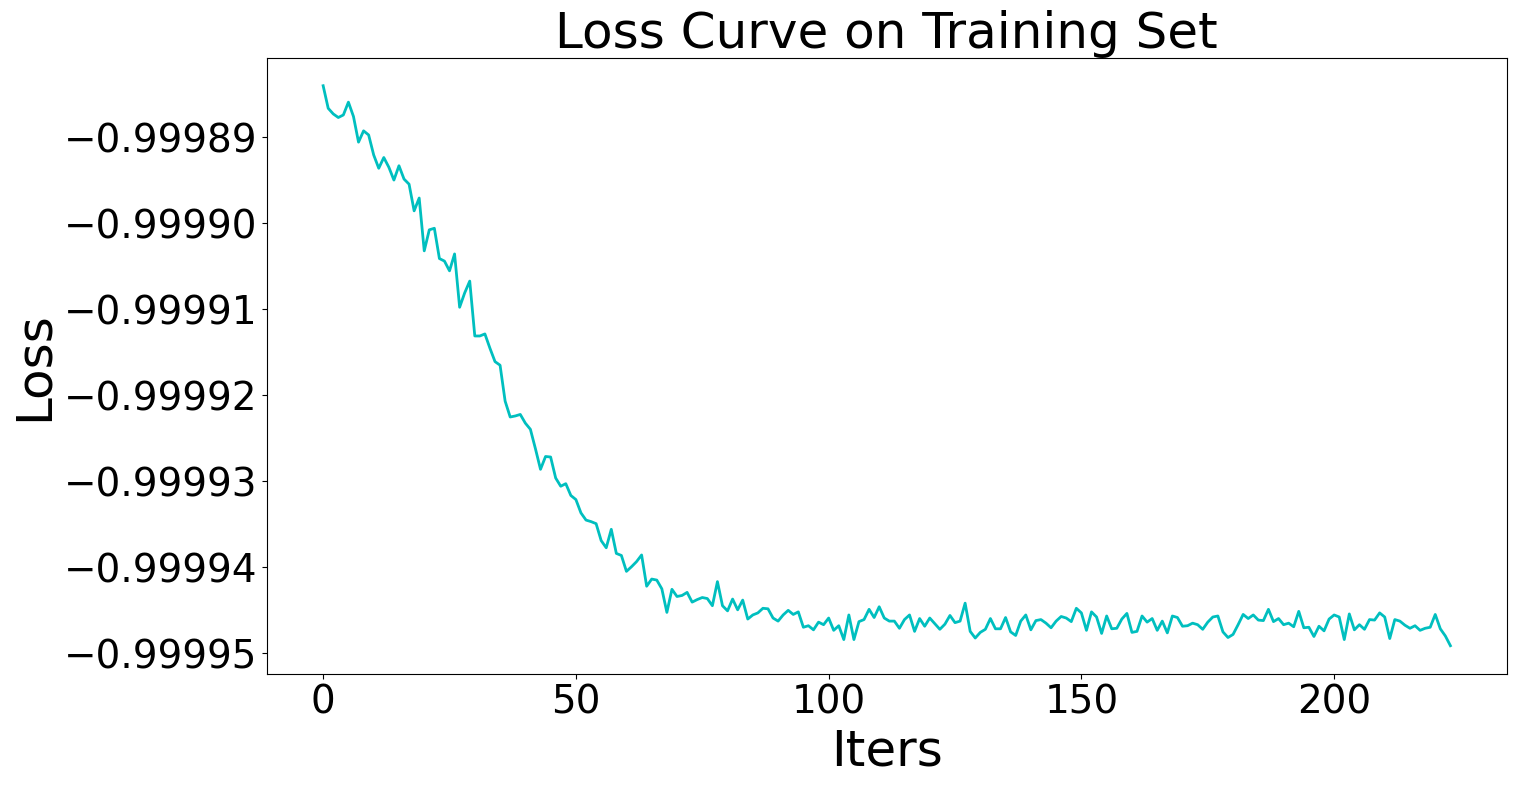

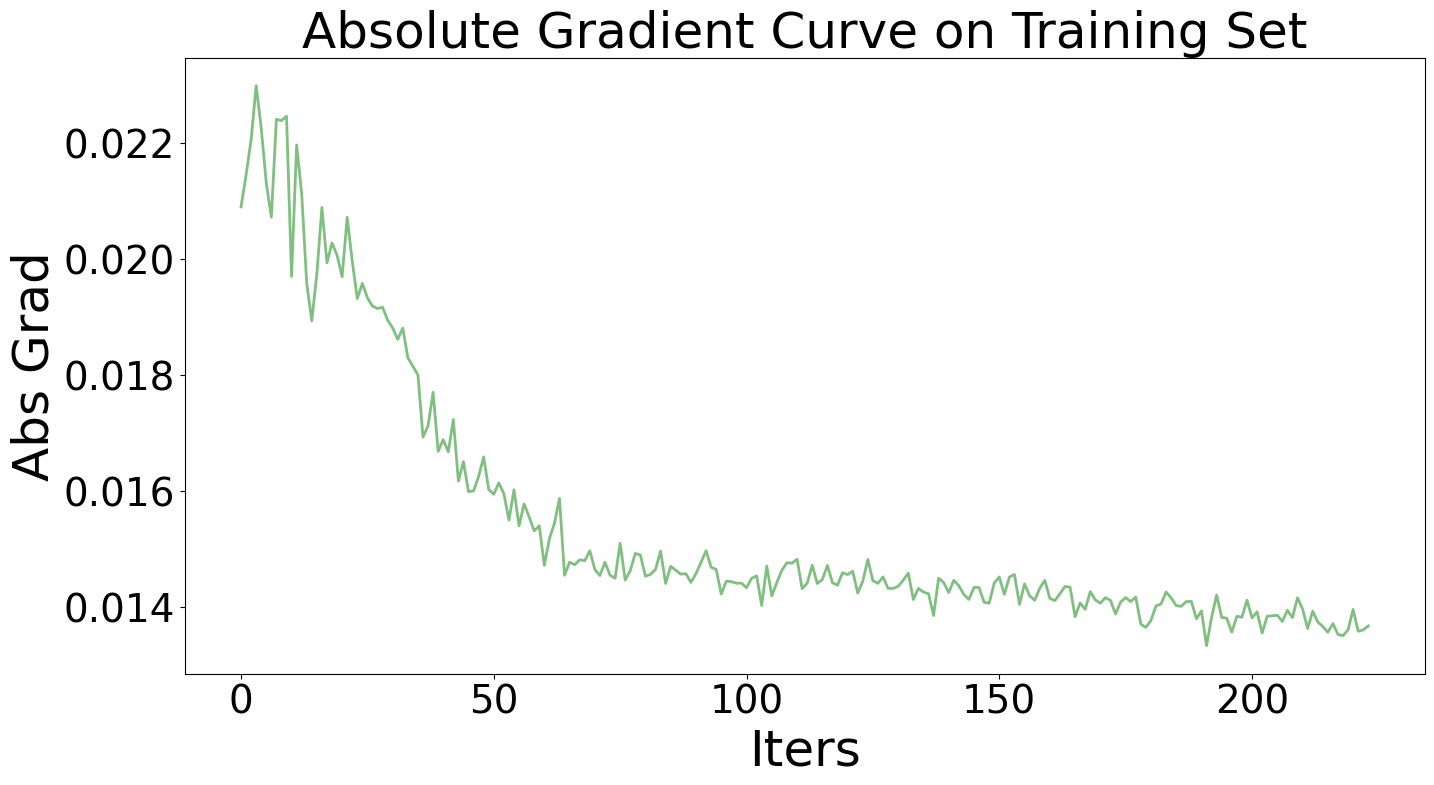

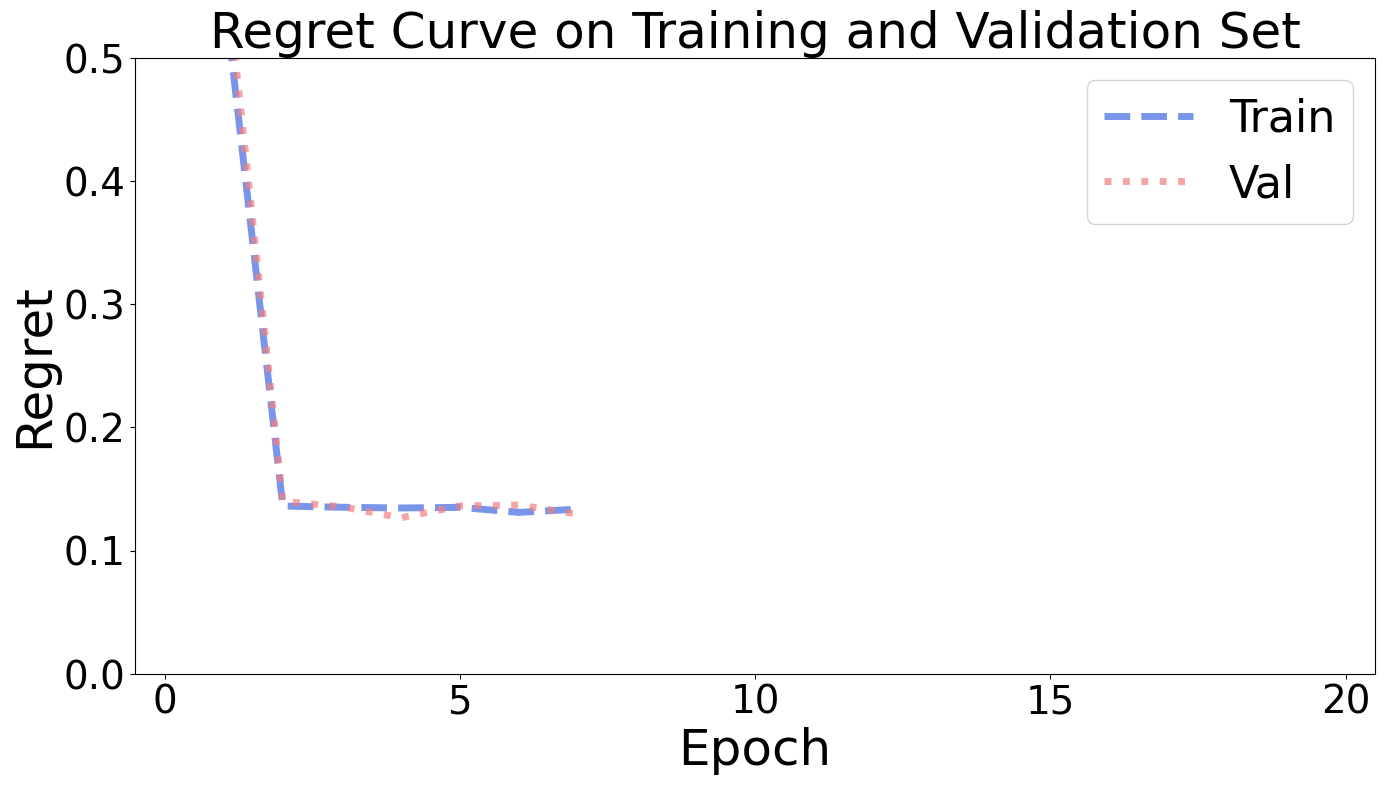

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### 1000 Samples 

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=1000)

Num of cores: 1


In [22]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:10<?, ?it/s]

Epoch   0, Train Regret: 201.6410%, Val Regret: 214.9158%


Epoch    0, Loss:  -0.9999:   5%|██▊                                                    | 1/20 [00:29<05:57, 18.80s/it]

Epoch   1, Train Regret:  62.3356%, Val Regret:  65.5411%


Epoch    1, Loss:  -0.9999:  10%|█████▌                                                 | 2/20 [00:45<05:19, 17.74s/it]

Epoch   2, Train Regret:  13.5932%, Val Regret:  15.3628%


Epoch    2, Loss:  -1.0000:  15%|████████▎                                              | 3/20 [01:01<04:48, 16.94s/it]

Epoch   3, Train Regret:  13.4968%, Val Regret:  13.8771%


Epoch    3, Loss:  -1.0000:  20%|███████████                                            | 4/20 [01:19<04:28, 16.80s/it]

Epoch   4, Train Regret:  12.9550%, Val Regret:  13.2432%


Epoch    4, Loss:  -1.0000:  25%|█████████████▊                                         | 5/20 [01:35<04:14, 16.93s/it]

Epoch   5, Train Regret:  12.9655%, Val Regret:  12.4972%


Epoch    5, Loss:  -0.9999:  30%|████████████████▌                                      | 6/20 [01:51<03:53, 16.65s/it]

Epoch   6, Train Regret:  13.6860%, Val Regret:  13.7715%


Epoch    6, Loss:  -1.0000:  35%|███████████████████▎                                   | 7/20 [02:09<03:36, 16.68s/it]

Epoch   7, Train Regret:  13.1648%, Val Regret:  13.7331%


Epoch    7, Loss:  -1.0000:  40%|██████████████████████                                 | 8/20 [02:27<03:40, 18.40s/it]


Epoch   8, Train Regret:  13.3974%, Val Regret:  13.5915%

Early Stop!

Evaluation:
Test Regret: 13.7534%
Training Elapsed Time: 45.24 Sec


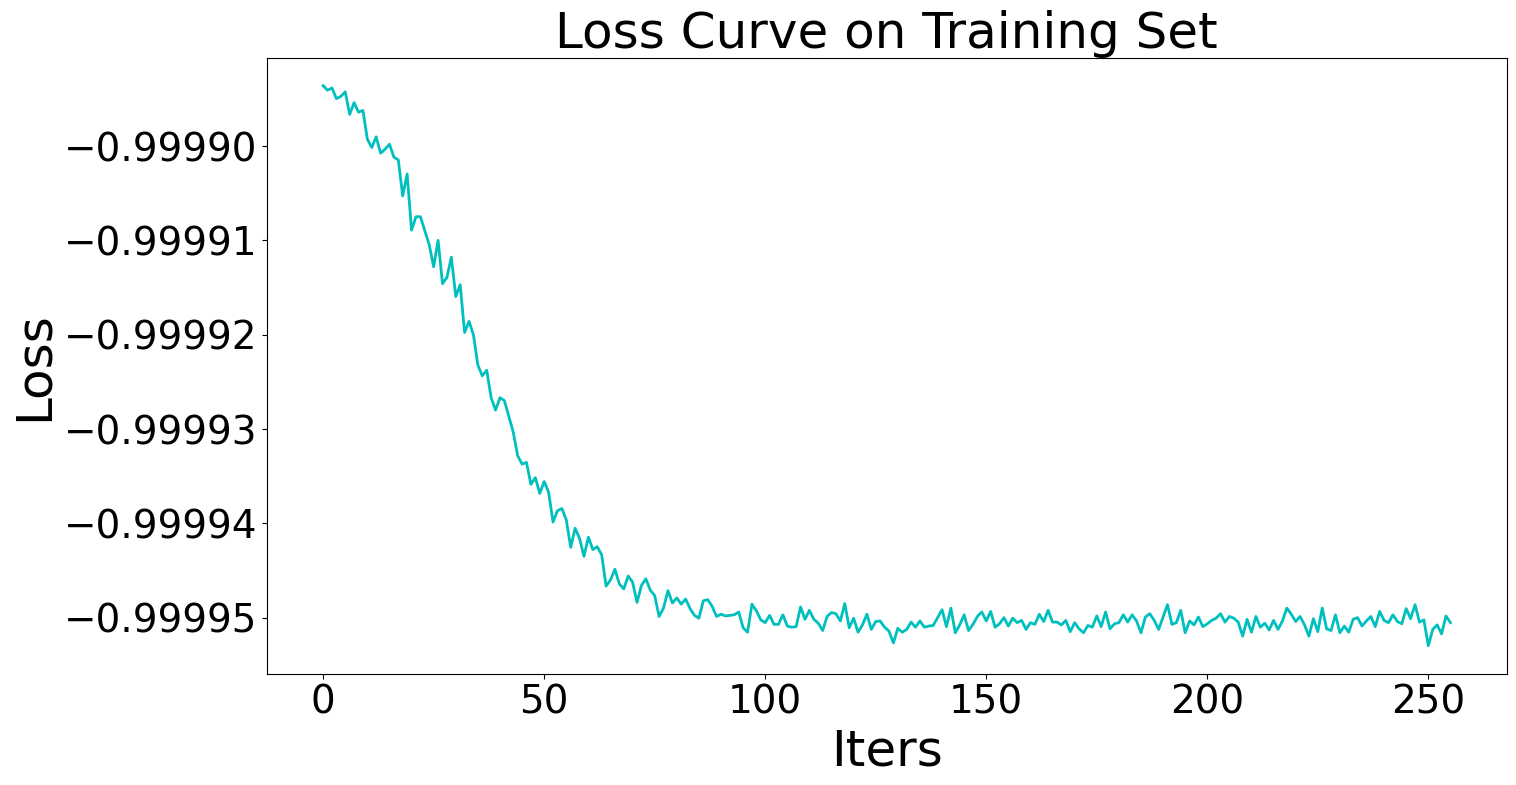

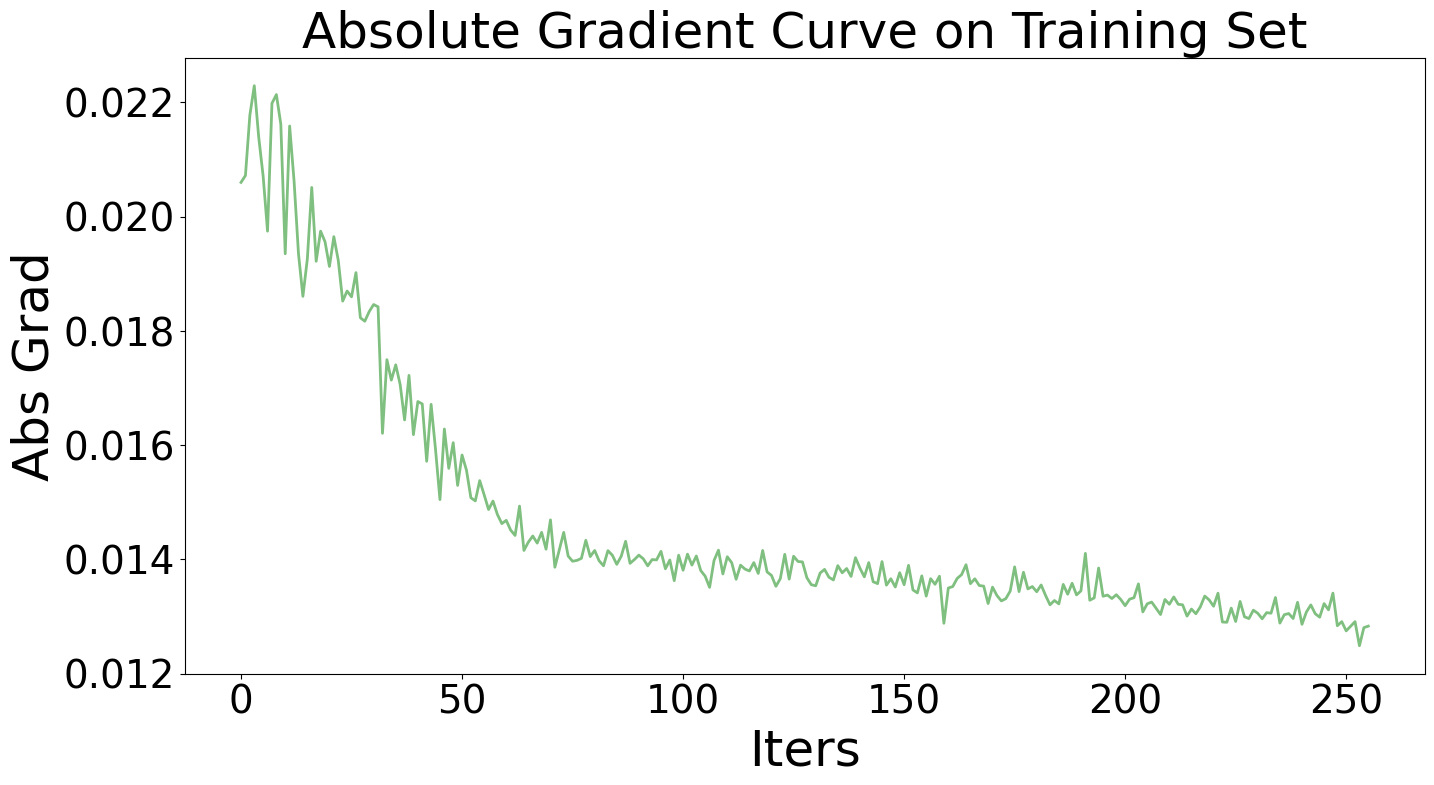

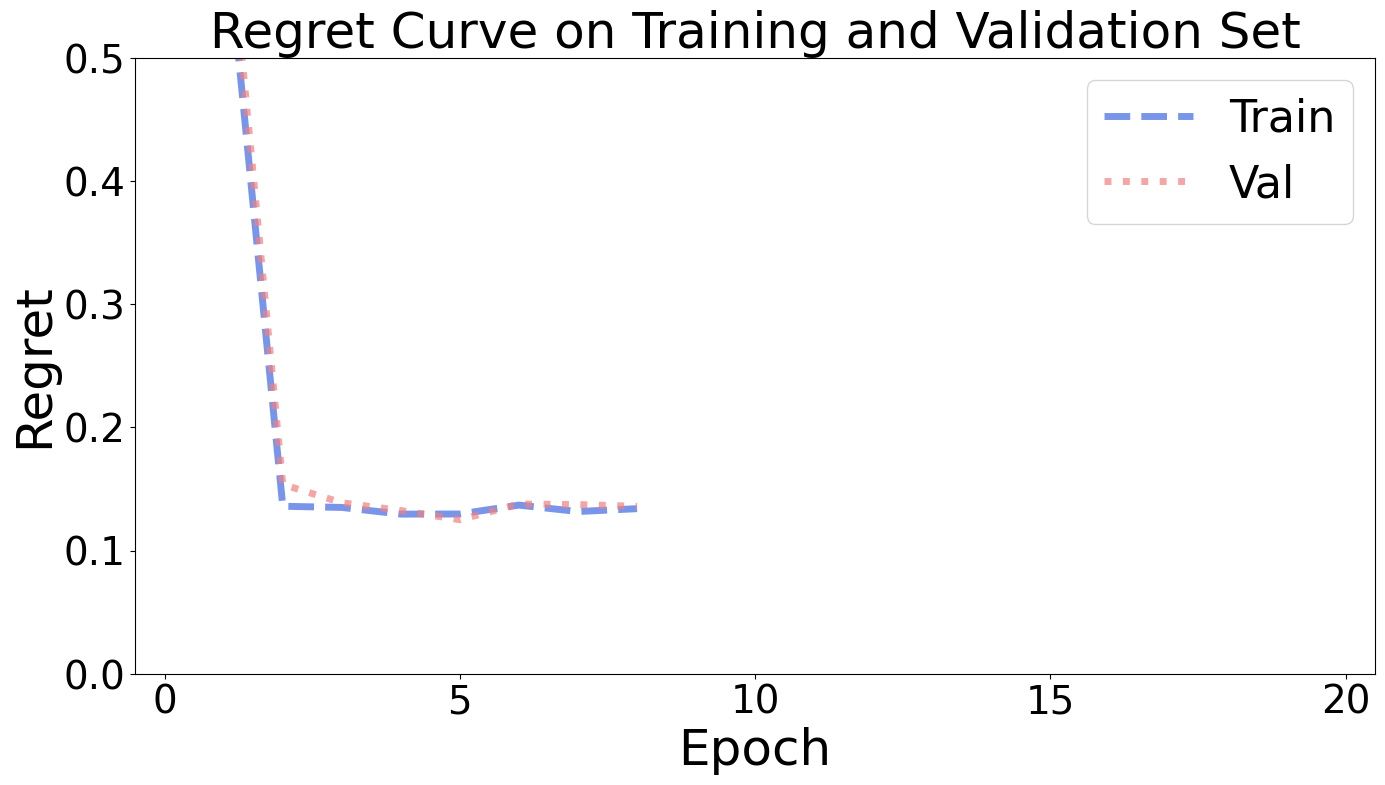

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)